In [2]:
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, InputLayer, \
    Flatten, Dense, Dropout, GlobalAveragePooling2D, MaxPooling2D, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.initializers import Constant
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, classification_report
from tensorflow.image import rgb_to_grayscale, resize

In [3]:
def prepare_data(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets
    
    ds = ds.map(lambda x, y: (rgb_to_grayscale(x), y))
    
#     ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
#               num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Use data augmentation only on the training set
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

    # Use buffered prefecting on all datasets
    return ds.prefetch(buffer_size=AUTOTUNE)

In [4]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256, 256),
  layers.experimental.preprocessing.Rescaling(1./255)
])

In [5]:
data_augmentation = tf.keras.Sequential([
layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
layers.experimental.preprocessing.RandomRotation(0.2),
layers.experimental.preprocessing.RandomHeight(0.1),
layers.experimental.preprocessing.RandomWidth(0.1),
layers.experimental.preprocessing.RandomZoom(0.1),
])

In [6]:
metadata = pd.read_csv('data/Chest_xray_Corona_Metadata.csv').drop('Unnamed: 0', axis=1)
metadata.head()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [7]:
metadata['Label'].value_counts()

Pnemonia    4334
Normal      1576
Name: Label, dtype: int64

In [8]:
image_root_path = 'data/'

In [9]:
batch_size = 50
input_shape = (256, 256, 1)
AUTOTUNE = tf.data.AUTOTUNE

In [10]:
train_data = image_dataset_from_directory(
    'data/train/',
    labels='inferred',
    batch_size=batch_size,
    image_size=input_shape[:2],
    seed=1,
    validation_split=0.2,
    subset='training'
)

Found 5286 files belonging to 2 classes.
Using 4229 files for training.


In [11]:
validation_data = image_dataset_from_directory(
    'data/train/',
    labels='inferred',
    batch_size=batch_size,
    image_size=input_shape[:2],
    seed=1,
    validation_split=0.2,
    subset='validation'
)

Found 5286 files belonging to 2 classes.
Using 1057 files for validation.


In [12]:
test_data = image_dataset_from_directory(
    'data/test/',
    labels='inferred',
    image_size=input_shape[:2]
)

Found 624 files belonging to 2 classes.


In [13]:
train_data_pf = prepare_data(train_data, shuffle=True, augment=True)
validation_data_pf = prepare_data(validation_data)
test_data_pf = prepare_data(test_data)

In [14]:
# Calculate class weights to balance data
unique_classes = metadata.Label.unique()
all_rows = metadata.Label.to_numpy()
weights = compute_class_weight('balanced', classes=unique_classes, y=all_rows)

In [15]:
# set initial output bias for model to speed up convergence
initial_bias = Constant(weights[1] / weights[0])

In [56]:
def create_model():
    model = Sequential([
        Conv2D(32, 3),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        BatchNormalization(),
        Conv2D(64, 5),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        BatchNormalization(),
        Conv2D(128, 9),
        BatchNormalization(),
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid', bias_initializer=initial_bias)
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [57]:
model = create_model()

In [58]:
checkpoint_path = 'model checkpoints/shallow_cnn/'

In [59]:
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2
)

In [60]:
history = model.fit(
    train_data_pf,
    batch_size=batch_size,
    callbacks=[checkpoint, early_stopping],
    epochs=10,
    validation_data=validation_data_pf,
    verbose=1
)

Epoch 1/10
85/85 [==============================] - 139s 1s/step - loss: 0.3385 - accuracy: 0.8501 - val_loss: 13.9551 - val_accuracy: 0.2498
Epoch 2/10
85/85 [==============================] - 111s 1s/step - loss: 0.3053 - accuracy: 0.8631 - val_loss: 5.0130 - val_accuracy: 0.2498
Epoch 3/10
85/85 [==============================] - 87s 862ms/step - loss: 0.3142 - accuracy: 0.8567 - val_loss: 3.3850 - val_accuracy: 0.2498
Epoch 4/10
85/85 [==============================] - 81s 798ms/step - loss: 0.3101 - accuracy: 0.8603 - val_loss: 0.2536 - val_accuracy: 0.9139
Epoch 5/10
85/85 [==============================] - 73s 695ms/step - loss: 0.3065 - accuracy: 0.8576 - val_loss: 1.5344 - val_accuracy: 0.3254
Epoch 6/10
85/85 [==============================] - 67s 621ms/step - loss: 0.3032 - accuracy: 0.8669 - val_loss: 2.4258 - val_accuracy: 0.2658


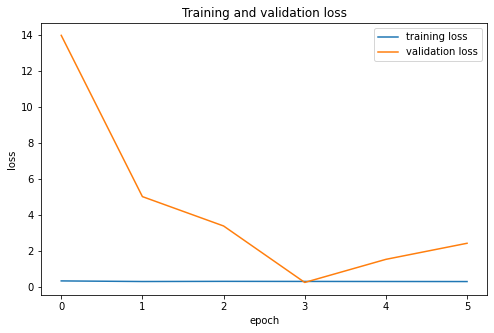

In [61]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.show()

In [62]:
model.load_weights(checkpoint_path)

In [63]:
y_proba = model.predict(test_data_pf)

In [64]:
iterator = iter(test_data)
y_test = np.array([])
for i in iterator:
    y_test = np.concatenate([y_test, i[1].numpy()])

In [65]:
y_test

array([0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
       0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
       1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0.,
       1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
       1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 0., 1.

In [66]:
y_pred = np.where(y_proba >= 0.5, 1, 0)

In [67]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.36      0.22      0.28       234
         1.0       0.62      0.77      0.69       390

    accuracy                           0.56       624
   macro avg       0.49      0.49      0.48       624
weighted avg       0.52      0.56      0.53       624



In [ ]:
y_pred.mean()